In [53]:
# Installation des dépendances pour SAM
import subprocess
import sys

def install_if_missing(package, import_name=None):
    """Installe un package s'il n'est pas déjà disponible."""
    if import_name is None:
        import_name = package
    
    try:
        __import__(import_name)
        print(f"✅ {package} déjà disponible")
        return True
    except ImportError:
        print(f"⚠️ Installation de {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
            __import__(import_name)
            print(f"✅ {package} installé avec succès")
            return True
        except Exception as e:
            print(f"❌ Erreur lors de l'installation de {package}: {e}")
            return False

# Installer les packages nécessaires
packages = [
    ("transformers", "transformers"),
    ("torch", "torch"),
    ("torchvision", "torchvision"),
    ("pillow", "PIL"),
    ("matplotlib", "matplotlib"),
    ("numpy", "numpy"),
    ("opencv-python", "cv2"),
    ("requests", "requests")
]

print("🔍 Vérification et installation des dépendances SAM...")
all_success = True
for package, import_name in packages:
    if not install_if_missing(package, import_name):
        all_success = False

if all_success:
    print("\n🚀 Toutes les dépendances SAM sont prêtes!")
else:
    print("\n⚠️ Certaines dépendances n'ont pas pu être installées.")

🔍 Vérification et installation des dépendances SAM...
✅ transformers déjà disponible
✅ torch déjà disponible
✅ torchvision déjà disponible
✅ pillow déjà disponible
✅ matplotlib déjà disponible
✅ numpy déjà disponible
✅ opencv-python déjà disponible
✅ requests déjà disponible

🚀 Toutes les dépendances SAM sont prêtes!
✅ matplotlib déjà disponible
✅ numpy déjà disponible
✅ opencv-python déjà disponible
✅ requests déjà disponible

🚀 Toutes les dépendances SAM sont prêtes!


### Lab Segment Anything

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI.

The full lab can be found at https://learn.deeplearning.ai/

In [33]:
from transformers import pipeline

In [34]:
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]
Device set to use cpu


In [35]:
from PIL import Image
import requests

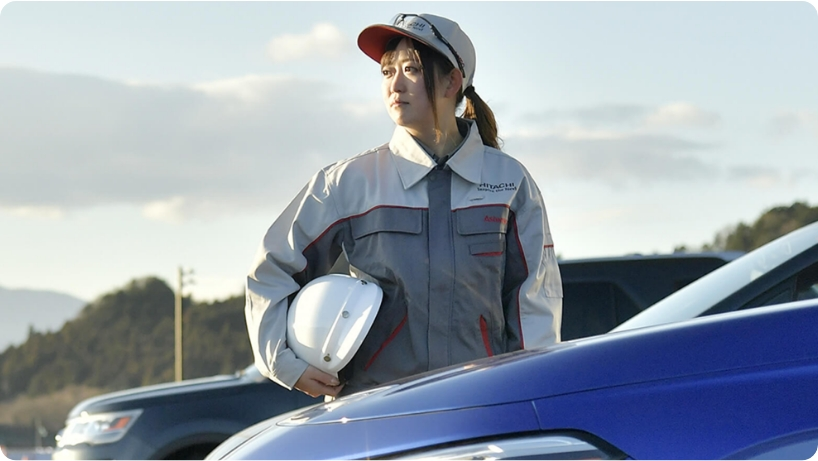

In [36]:
url = "https://www.lalux.lu/fileadmin/_processed_/3/b/csm_1600x1024_Easylifepension_LandingPage_b8ae391df1.jpg"
url = "https://www.astemo.com/en/assets/images/corporate/thumb_corporate09.jpg"

raw_image = Image.open(requests.get(url, stream=True).raw)

raw_image

In [37]:
output = sam_pipe(raw_image, points_per_batch=32)

In [54]:
# Fonctions de visualisation pour SAM (remplacement helper_Img_Seg)
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_pipe_masks_on_image(image, output, num_masks_to_show=5):
    """Affiche les masques générés par le pipeline SAM sur l'image."""
    plt.figure(figsize=(15, 10))
    
    # Image originale
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title("Image Originale")
    plt.axis('off')
    
    # Afficher les premiers masques
    masks = output["masks"]
    scores = output["scores"]
    
    for i in range(min(num_masks_to_show, len(masks))):
        plt.subplot(2, 3, i + 2)
        
        # Convertir l'image en array numpy
        img_array = np.array(image)
        
        # Créer une version colorée du masque
        colored_mask = np.zeros_like(img_array)
        mask = masks[i]
        colored_mask[mask] = [255, 0, 0]  # Rouge pour le masque
        
        # Superposer le masque sur l'image
        overlay = cv2.addWeighted(img_array, 0.7, colored_mask, 0.3, 0)
        
        plt.imshow(overlay)
        plt.title(f"Masque {i+1} (Score: {scores[i]:.3f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def show_mask_on_image(image, mask, alpha=0.5, color_mask=None):
    """Affiche un masque spécifique sur l'image."""
    plt.figure(figsize=(10, 6))
    
    # Convertir l'image en array numpy si nécessaire
    if hasattr(image, 'convert'):
        img_array = np.array(image.convert('RGB'))
    else:
        img_array = np.array(image)
    
    # Convertir le masque en numpy array
    if hasattr(mask, 'cpu'):
        mask_array = mask.cpu().numpy()
    else:
        mask_array = np.array(mask)
    
    # Squeeze pour enlever les dimensions unitaires
    if mask_array.ndim > 2:
        mask_array = mask_array.squeeze()
    
    # Créer un masque coloré
    if color_mask is None:
        color_mask = np.array([255, 0, 0])  # Rouge par défaut
    
    colored_mask = np.zeros_like(img_array)
    colored_mask[mask_array > 0.5] = color_mask
    
    # Superposer le masque sur l'image
    overlay = cv2.addWeighted(img_array, 1-alpha, colored_mask, alpha, 0)
    
    plt.imshow(overlay)
    plt.title("Segmentation avec SAM")
    plt.axis('off')
    plt.show()

def show_masks_grid(image, masks, scores=None, max_masks=9):
    """Affiche une grille de masques."""
    num_masks = min(len(masks), max_masks)
    cols = 3
    rows = (num_masks + cols - 1) // cols
    
    plt.figure(figsize=(15, 5 * rows))
    
    for i in range(num_masks):
        plt.subplot(rows, cols, i + 1)
        
        # Convertir l'image en array numpy
        img_array = np.array(image)
        
        # Créer le masque coloré
        colored_mask = np.zeros_like(img_array)
        mask = masks[i]
        if hasattr(mask, 'cpu'):
            mask = mask.cpu().numpy()
        if mask.ndim > 2:
            mask = mask.squeeze()
        
        colored_mask[mask > 0.5] = [0, 255, 0]  # Vert
        
        # Superposer
        overlay = cv2.addWeighted(img_array, 0.7, colored_mask, 0.3, 0)
        
        plt.imshow(overlay)
        if scores is not None and i < len(scores):
            plt.title(f"Masque {i+1} (Score: {scores[i]:.3f})")
        else:
            plt.title(f"Masque {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ Fonctions de visualisation SAM chargées!")

✅ Fonctions de visualisation SAM chargées!


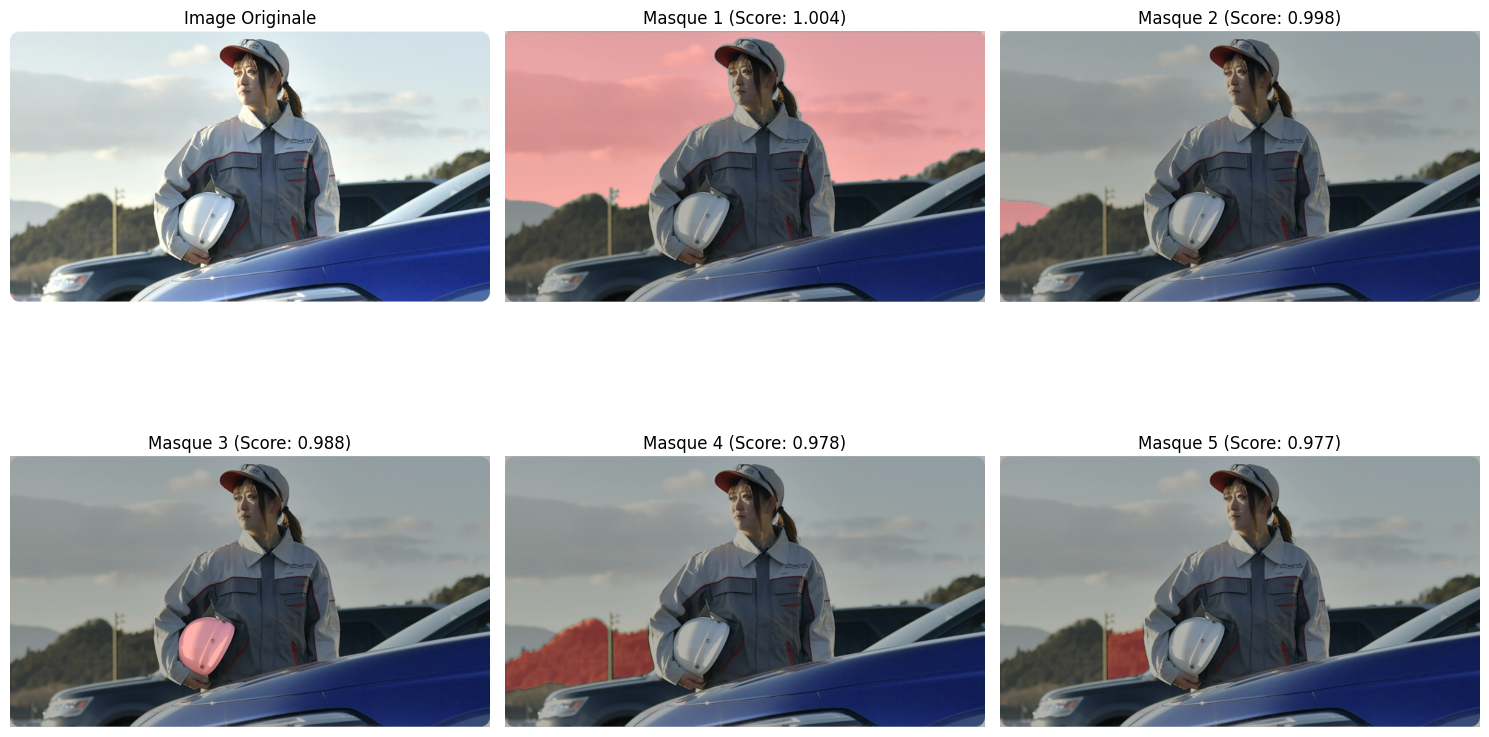

In [55]:
# Affichage des masques générés par le pipeline
if 'output' in locals():
    show_pipe_masks_on_image(raw_image, output)
else:
    print("⚠️ Exécutez d'abord la cellule de génération de masques (sam_pipe)")

### Inférence à partir d'un point

In [40]:
from transformers import SamModel, SamProcessor

In [41]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 3204.20it/s]


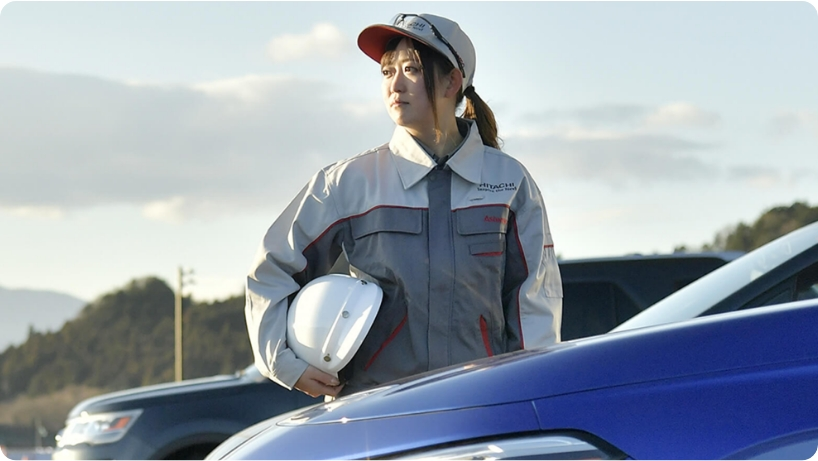

In [42]:
raw_image = Image.open(requests.get(url, stream=True).raw)
# raw_image = Image.open("csm_Cover-Pic_spot_notoriete_092024_b58917bdd7.jpg")
raw_image

- Segmentation pour shirt orange
- Donnez les coordonnées d'un point situé dans la région (ex: t-shirt orange).

In [43]:
input_points = [[[400, 250]]]

In [44]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

In [45]:
import torch

In [46]:
with torch.no_grad():
    outputs = model(**inputs)

In [47]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

In [48]:
len(predicted_masks)

1

In [49]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 461, 818])

In [50]:
outputs.iou_scores

ModuleNotFoundError: No module named 'torch._subclasses.schema_check_mode'

🎯 Affichage des 3 masques prédits pour le point sélectionné:

--- Masque 1 ---


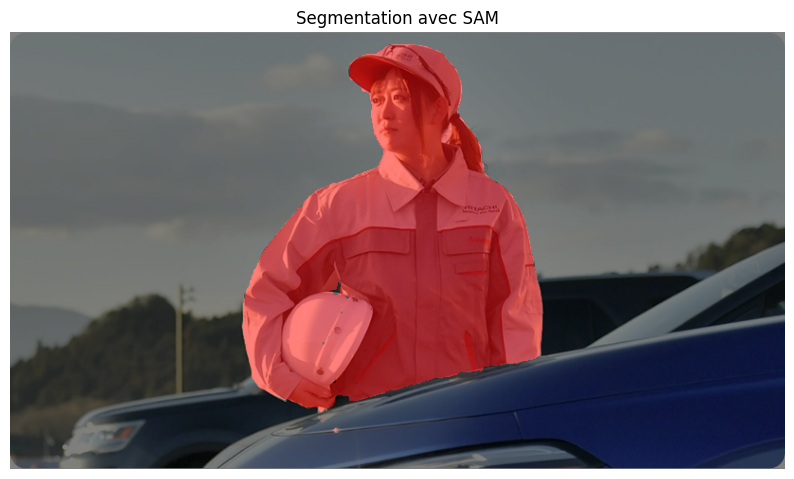


--- Masque 2 ---


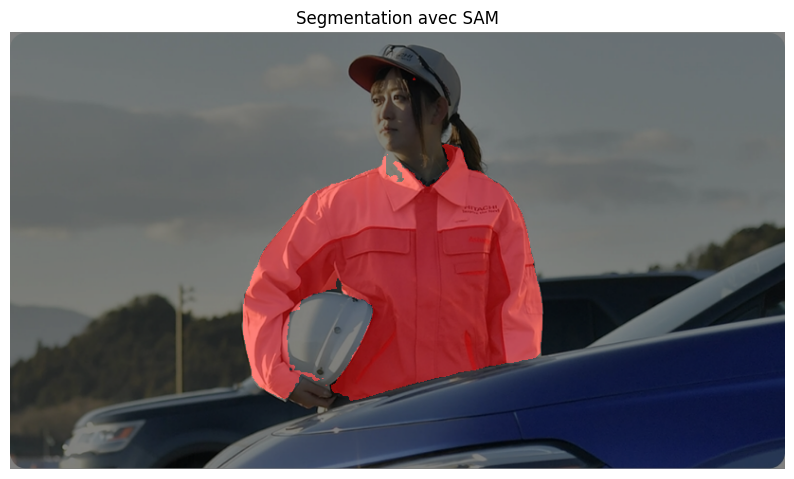


--- Masque 3 ---


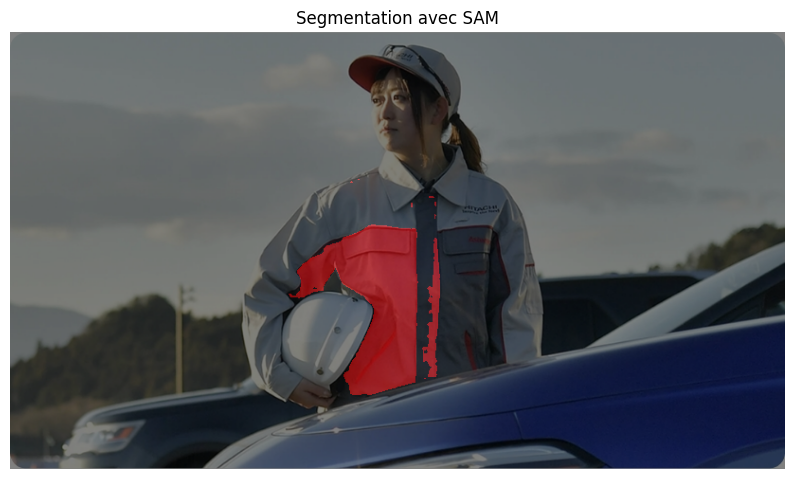

In [56]:
# Affichage des masques prédits pour la segmentation par point
if 'predicted_mask' in locals():
    print("🎯 Affichage des 3 masques prédits pour le point sélectionné:")
    for i in range(min(3, predicted_mask.shape[1])):
        print(f"\n--- Masque {i+1} ---")
        show_mask_on_image(raw_image, predicted_mask[:, i])
else:
    print("⚠️ Exécutez d'abord les cellules de prédiction de masques")

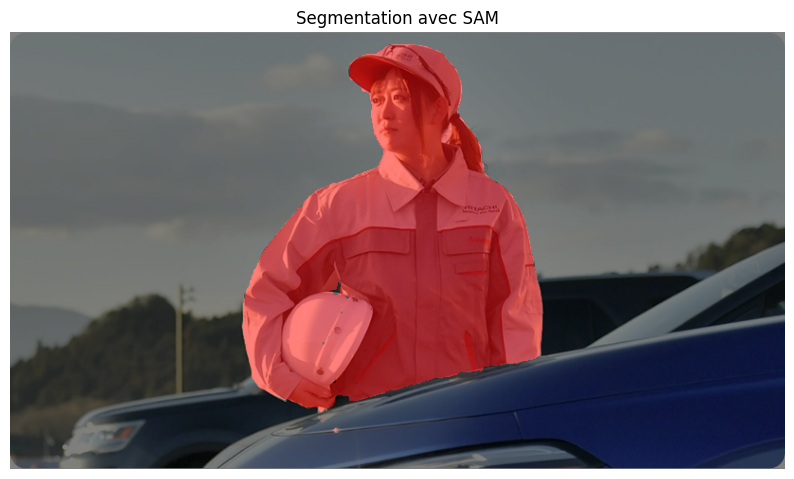

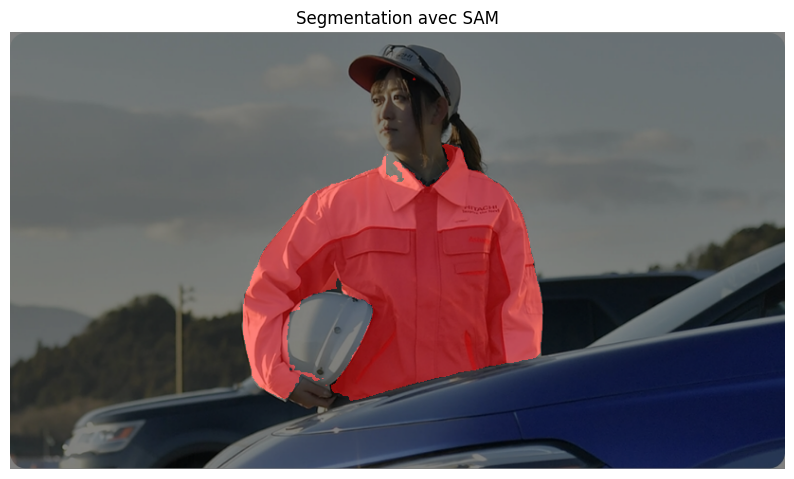

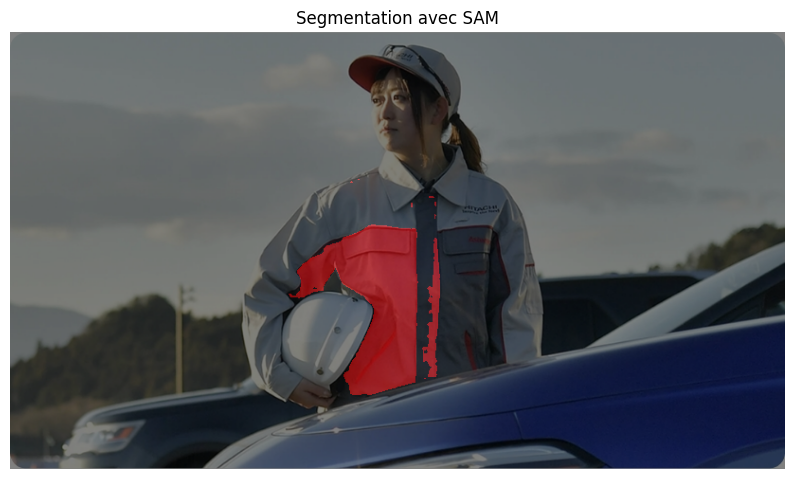

In [ ]:
 for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

📊 Analyse des résultats SAM:
   - Nombre de masques prédits: 3
   - Dimensions du masque: torch.Size([1, 3, 461, 818])
   - Scores IoU: [[[0.9265635013580322, 0.889015257358551, 0.7418570518493652]]]
   - Meilleur masque: #1 (IoU: 0.927)

🎯 Affichage du meilleur masque:


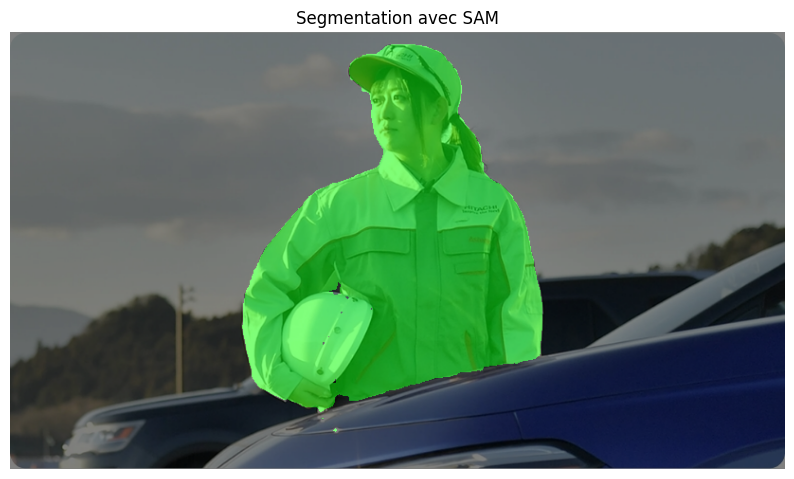

In [60]:
# Analyse des résultats de segmentation
if 'outputs' in locals() and 'predicted_mask' in locals():
    print("📊 Analyse des résultats SAM:")
    print(f"   - Nombre de masques prédits: {predicted_mask.shape[1]}")
    print(f"   - Dimensions du masque: {predicted_mask.shape}")
    print(f"   - Scores IoU: {outputs.iou_scores.tolist()}")
    
    # Afficher le meilleur masque (score IoU le plus élevé)
    best_mask_idx = outputs.iou_scores.argmax().item()
    print(f"   - Meilleur masque: #{best_mask_idx + 1} (IoU: {outputs.iou_scores.flatten()[best_mask_idx].item():.3f})")
    
    print(f"\n🎯 Affichage du meilleur masque:")
    show_mask_on_image(raw_image, predicted_mask[:, best_mask_idx], color_mask=np.array([0, 255, 0]))
else:
    print("⚠️ Aucun résultat de segmentation disponible")